In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist

/Users/anuunchinbat/Desktop/Thesis/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [3]:
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

loss, accuracy = model.evaluate(x_test, y_test)
print(f'Baseline Test Accuracy: {accuracy}')

model.save("./saved_unquantized_model")

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2573 - accuracy: 0.9259 - val_loss: 0.1458 - val_accuracy: 0.9580
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1142 - accuracy: 0.9663 - val_loss: 0.1004 - val_accuracy: 0.9693
Epoch 3/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0774 - accuracy: 0.9765 - val_loss: 0.0827 - val_accuracy: 0.9748
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0573 - accuracy: 0.9822 - val_loss: 0.0762 - val_accuracy: 0.9776
Epoch 5/5
313/313 [==============================] - 0s 841us/step - loss: 0.0680 - accuracy: 0.9792
Baseline Test Accuracy: 0.979200005531311
INFO:tensorflow:Assets written to: ./saved_unquantized_model/assets


INFO:tensorflow:Assets written to: ./saved_unquantized_model/assets


In [4]:
quantized_model = tfmot.quantization.keras.quantize_model(model)
quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

quantized_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 28, 28, 1)         3         
 yer)                                                            
                                                                 
 quant_flatten (QuantizeWra  (None, 784)               1         
 pperV2)                                                         
                                                                 
 quant_dense (QuantizeWrapp  (None, 128)               100485    
 erV2)                                                           
                                                                 
 quant_dense_1 (QuantizeWra  (None, 10)                1295      
 pperV2)                                                         
                                                                 
Total params: 101784 (397.59 KB)
Trainable params: 10177

In [7]:
quantized_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.1022 - val_accuracy: 0.9765
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0060 - accuracy: 0.9982 - val_loss: 0.0992 - val_accuracy: 0.9787
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.1052 - val_accuracy: 0.9799
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.0996 - val_accuracy: 0.9800
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0064 - accuracy: 0.9978 - val_loss: 0.1000 - val_accuracy: 0.9796


In [8]:
loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Baseline Test Accuracy: {accuracy}')

313/313 [==============================] - 0s 1ms/step - loss: 0.1000 - accuracy: 0.9796
Baseline Test Accuracy: 0.9796000123023987


In [9]:
quantized_model.save("./saved_quantized_model")

INFO:tensorflow:Assets written to: ./saved_quantized_model/assets


INFO:tensorflow:Assets written to: ./saved_quantized_model/assets


In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open('quantized_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: /var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/tmpgodx3ke9/assets


INFO:tensorflow:Assets written to: /var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/tmpgodx3ke9/assets
/Users/anuunchinbat/Desktop/Thesis/myenv/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-05-27 10:35:09.646868: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-27 10:35:09.646887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-27 10:35:09.647256: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/tmpgodx3ke9
2024-05-27 10:35:09.649219: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-27 10:35:09.649231: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/ms/xd16k27j2lj0dx3

In [11]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

accuracy = 0
for i in range(len(x_test)):
    interpreter.set_tensor(input_index, x_test[i:i+1]) # single test input with slicing x_test[i:i+1] ensures the data is in the correct shape
    interpreter.invoke() # run inference
    output = interpreter.get_tensor(output_index)
    prediction = np.argmax(output[0]) # choose highest predictable 
    if prediction == y_test[i]:
        accuracy += 1

accuracy /= len(x_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

Quantized Model Test Accuracy: 0.9796


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
import random

random_indices = random.sample(range(x_test.shape[0]), 10)
print(random_indices)
random_images = x_test[random_indices]
random_labels = y_test[random_indices]

output_details = interpreter.get_output_details()

[5576, 3972, 850, 175, 5281, 7279, 8640, 59, 1452, 5141]


In [23]:
predictions = []

for img in random_images:
    input_data = np.expand_dims(img, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_index)
    predictions.append(np.argmax(output_data))

# Convert predictions and labels to numpy arrays for consistency
predictions = np.array(predictions)
random_labels = np.array(random_labels)

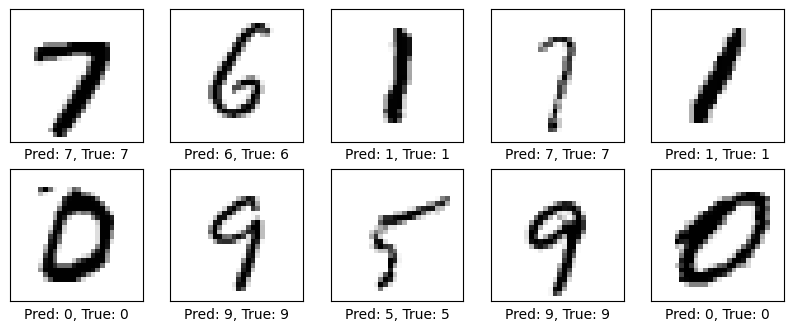

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(len(random_indices)):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(random_images[i], cmap=plt.cm.binary)
    plt.xlabel(f"Pred: {predictions[i]}, True: {random_labels[i]}")
plt.show()